# SF task: Known unknowns

In this exercise we would like you to:

- build SOTA solution for image classification,
- find a way to find out if your model works really bad


### SOTA CNN Solution for image classification.

In this task you need to build a CNN model which:

- will be trained on a [`cifar 10`](https://www.cs.toronto.edu/~kriz/cifar.html), 
- will have a stem like in `ResNet 50`, 
- will have at least one skip connection,

A properly solved task should consist of:
- a code cell with a `stem` definition with appropriate citation and image added,
- a code cell with a skip-connection definition with appropriate image added,
- training a model on `CIFAR 10` which achieves at least 70% of accuracy on a test set from `CIFAR 10`.


### Diving into knowing about what do we don't know

The second task is to assess the certainty of your classifier. Your task is to propose a certainty metric which based on your model - will make prediction if a given prediction can be trusted or not.

A properly solved task should consist of:
- a code cell with definition of your metric and a text cell with its explaination,
- a code cell with a histogram of this metric for both properly classified and misclassified examples from CIFAR 10 dataset (histogram should compare distribution of your metric on properly and wrongly classified data).


### Code wrap up: 

Please wrap up your model in the following class as it will be tested against additional dataset:


    class Model:
        
        def predict(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of predicted classes.

        def certainty(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of certainty levels.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pytorch_lightning as pl

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
class Block(nn.Module):
    def __init__(self, channels, start_expansion, end_expansion, stride=1):
        super(Block, self).__init__()
        self.start_expansion = start_expansion
        self.end_expansion = end_expansion

        self.conv_1 = nn.Conv2d(in_channels=channels*self.start_expansion, out_channels=channels, kernel_size=1, stride=stride)
        self.batch_norm_1 = nn.BatchNorm2d(channels)
        self.conv_2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=stride)
        self.batch_norm_2 = nn.BatchNorm2d(channels)
        self.conv_3 = nn.Conv2d(in_channels=channels, out_channels=self.end_expansion*channels, kernel_size=1, stride=stride)
        self.batch_norm_3 = nn.BatchNorm2d(self.end_expansion*channels)

        residual_rescale = nn.Sequential(
                nn.Conv2d(channels*self.start_expansion, channels*self.end_expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(channels*self.start_expansion)
            )

        self.relu = nn.ReLU()

        def forward(self, x):
            input_x = x.clone()
            x = self.relu(self.batch_norm_1(self.conv_1(x)))
            x = self.relu(self.batch_norm_2(self.conv_2(x)))
            x = self.batch_norm_3(self.conv_3(x))

            if self.start_expansion != self.end_expansion:
                input_x = residual_rescale(input_x)
            
            # skip connection
            x = self.relu(x + input_x)

            return x

class MyResNet50(pl.LightningModule):
    def __init__(self, lr):
        super(MyResNet50, self).__init__()
        self.in_channels = 64
        self.expansion = 4
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

        self.input_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.blocks_layers_1 = self.make_initial_blocks_layer(sublayers_num=3, bl_channels=64)
        self.blocks_layers_2 = self.make_blocks_layer(sublayers_num=4, bl_channels=128)
        self.blocks_layers_3 = self.make_blocks_layer(sublayers_num=6, bl_channels=256)
        self.blocks_layers_4 = self.make_blocks_layer(sublayers_num=3, bl_channels=512)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*self.expansion, 10)
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.input_conv(x)))
        x = self.max_pool(x)
        x = self.blocks_layers_1(x)
        x = self.blocks_layers_2(x)
        x = self.blocks_layers_3(x)
        x = self.blocks_layers_4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

    def make_initial_blocks_layer(self, sublayers_num, bl_channels):
        blocks_layers = []
        for i in range(sublayers_num):
            if i == 0:
                blocks_layers.append(Block(channels=bl_channels, start_expansion=1, end_expansion=self.expansion))
            else:
                blocks_layers.append(Block(channels=bl_channels, start_expansion=self.expansion, end_expansion=self.expansion))

        return nn.Sequential(*blocks_layers)

    def make_blocks_layer(self, sublayers_num, bl_channels):
        blocks_layers = []
        for i in range(sublayers_num):
            if i == 0:
                blocks_layers.append(Block(channels=bl_channels, start_expansion=2, end_expansion=self.expansion))
            else:
                blocks_layers.append(Block(channels=bl_channels, start_expansion=self.expansion, end_expansion=self.expansion))          
                

        return nn.Sequential(*blocks_layers)

    def training_step(self, batch, batch_nb):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds.float(), y.float())

        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_nb):
        x_val, y_val = batch
        preds_val = self(x_val)
        loss_val = self.loss_fn(preds_val.float(), y_val.float())

        self.log("validation_loss", loss_val, on_epoch=True)
        return loss_val
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, weight_decay=0.0001)
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5),
            "interval": "epoch",
            "monitor": "validation_loss",
            "frequency": 1
        },
    }

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


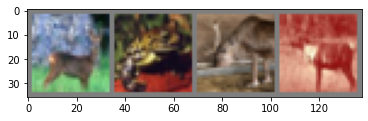

deer  frog  deer  deer 


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
model = MyResNet50()

trainer = pl.Trainer(max_epochs=50) #, accelerator='mps', devices=1)
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=testloader)

In [18]:
model = MyResNet50(lr=0.01)
print(model)

MyResNet50(
  (loss_fn): CrossEntropyLoss()
  (input_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (blocks_layers_1): Sequential(
    (0): Block(
      (conv_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv_1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1,